<a href="https://colab.research.google.com/github/atareen/Interpretable_Neural_Nets/blob/master/bp_neural_net_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install tensorflow --upgrade

     |████████████████████████████████| 86.3MB 41kB/s 
     |████████████████████████████████| 450kB 36.5MB/s 
     |████████████████████████████████| 3.8MB 28.5MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled

In [0]:
#!pip install keras --upgrade

In [0]:
!pip install logomaker

     |████████████████████████████████| 11.8MB 199kB/s 


In [0]:
from __future__ import division
import pandas as pd
import numpy as np
from numpy import argmax
from scipy import constants
import random

import os
import sys
import re
import pdb
import glob

#import suftware

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
import tensorflow.keras.backend as K

import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#%matplotlib inline
#plt.ion()

In [0]:
def mutate_sequence(con_seq, mut_rate):
    bases = ["A","C","G","T"]
    new_seq = list(con_seq)
    to_mutate = np.random.random(size = len(con_seq)) < mut_rate
    for i in range(0,len(to_mutate)):
        if to_mutate[i]:
            new_seq[i] = random.choice([b for b in bases if b not in new_seq[i]])
    return ''.join(new_seq)

# Fit a label encoder and a onehot encoder
bases = ["A","C","G","T"]
label_encoder = LabelEncoder()
label_encoder.fit(bases)
tmp = label_encoder.transform(bases)
tmp = tmp.reshape(len(tmp), 1)
onehot_encoder = OneHotEncoder(sparse = False)
onehot_encoder.fit(tmp)

# Encode sequence into onehot
def onehot_sequence(sequence, lab_encoder = label_encoder, one_encoder = onehot_encoder):
    """Sequence as a string"""
    tmp = lab_encoder.transform(list(sequence))
    tmp = tmp.reshape(len(tmp),1)
    tmp = one_encoder.transform(tmp)
    return tmp

# Calculate energy
def get_energy(seq_onehot, matrix_array):
    return np.sum(matrix_array * seq_onehot)

# Calculate boltzmann weight
def get_transcription(energy,mu=2.7):
    tau_max = 1.00
    return tau_max*(np.exp(-(energy-mu))/(1+np.exp(-(energy-mu))))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [0]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load the energy matrices from Kinney et al. 2010
crp_df = pd.read_csv('/content/drive/My Drive/energy_matrices/crp_tau_final_all.26.txt', sep = "\t", usecols = range(1,5))
rnap_df = pd.read_csv('/content/drive/My Drive/energy_matrices/rnap_tau_final_all.41.txt', sep = "\t", usecols = range(1,5))

# Convert the dataframe to numpy array for downstream processing
crp_array = pd.DataFrame.to_numpy(crp_df)
rnap_array = pd.DataFrame.to_numpy(rnap_df)

In [0]:
import pandas as pd
input_data_to_train_bp_nn = pd.read_csv("/content/drive/My Drive/train_bp_neural_network_on_this_and_recover_logos.csv")
del input_data_to_train_bp_nn['Unnamed: 0']

In [0]:
input_data_to_train_bp_nn.head()

,sequences,tau
0,ATTAATGTGAGTTAGCTCACTCATTACAGGCTTTACACTTTATGCT...,1.166998
1,ATTAATGTGAGTTAGCTCACTCATTACAGGCTTTACACTTTATGCT...,0.982927
2,ATTAATGTGAGTTAGCTCACTCATTACAGGCTTTACACTTTATGCT...,0.046503
3,ATTAATGTGAGTTAGCTCACTAATTACAGGCTTTACACTTTATGCT...,2.140138
4,ATTAATGTGAGTTAGCTCACTCTTTACAGGCTTTACACTTTATGCT...,2.213355


In [0]:
sequences = input_data_to_train_bp_nn['sequences'].values
val = input_data_to_train_bp_nn['tau']

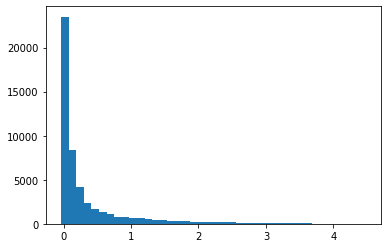

In [0]:
plt.hist(val,bins=40)
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(sequences, val, test_size=0.2)

In [0]:
######
## Define custom function for keras
######

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)


In [0]:
# convert the crp part of the sequence to one hot encoding
input_seqs_ohe = []
for _ in range(len(X_train)):
    input_seqs_ohe.append(onehot_sequence(X_train[_]))
    
test_seqs_ohe = []    
for _ in range(len(X_test)):
    test_seqs_ohe.append(onehot_sequence(X_test[_]))

In [0]:
X_train[0]

'ATTAATGTGAGTTAGCTCACTCATTACAGGCTTTACACTTGATGTTTCCGGCTCGTATGTTGTGTAG'

In [0]:
type(sequences)

numpy.ndarray

In [0]:
print(np.shape(input_seqs_ohe))
print(np.shape(test_seqs_ohe))

print(np.shape(y_train))
print(np.shape(y_test))

(39793, 67, 4)
(9949, 67, 4)
(39793,)
(9949,)


In [0]:
number_input_layer_nodes = len(input_seqs_ohe[0])*4 +1   
inputTensor = Input((number_input_layer_nodes,),name='Sequence')

In [0]:
number_input_layer_nodes

269

In [0]:
#import tensorflow as tf
from tensorflow.keras.layers import multiply

class CustomConnected(Dense):

    def __init__(self,units,connections, output_dim,**kwargs):
        
        self.output_dim = output_dim
        #this is matrix of connections. I.e., this should be [0,0,trainable,trainable]
        
        self.connections = connections                        

        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  

    @tf.function
    def call(self, inputs):
        print('connections',self.connections)
        print('inputs',inputs)
        kernel_times_connections = self.kernel*self.connections
        output = K.dot(inputs,kernel_times_connections)
        print('output',output)
        
        
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    

In [0]:
# # define two groups which represent binding sites for the two proteins crp and rnap

# group1 = Lambda(lambda x: x[:,0:104], output_shape=((104,)))(inputTensor)
# group2 = Lambda(lambda x: x[:,104:268], output_shape=((164,)))(inputTensor)
# group3 = Lambda(lambda x: x[:,268:269], output_shape=((1,)))(inputTensor)


# # From input to first hidden layer. The groups are connected to two nodes
# # node group1 represents energy of crp and group2 represents rnap energy.

# # rename group1 to crp pwm

# group1 = Dense(1,use_bias=True,name='CRP_pwm')(group1)
# group2 = Dense(1,use_bias=True,name='RNAP_pwm')(group2)
# group3 = Dense(1,use_bias=False,name='one-feature')(group3)

# #group2 = Dense(1,use_bias=False,name='RNAP_pwm',kernel_initializer='RandomNormal',W_constraint=nonneg())(group2)

# # the groups from the previous layer have to be concatenated so
# concatenateLayer = Concatenate()([group1,group2,group3])

# # gammaInput = Input(shape=(1,),name='gamma_Input')   # i.e. weights going into softmax: [0,0,0,1]
# # concatenateLayer_with_gamma = Concatenate()([group1,group2,gammaInput])


# # softmax layer needs to have multiple inputs

# # try custom connections in the trainable softmax
# #softmaxLayer = Dense(4,activation='softmax', trainable=True, use_bias=True,name='softmax_layer')(concatenateLayer)
# #softmaxLayer = CustomSoftmax(4,2)(concatenateLayer)
# #softmaxLayer = CustomSoftmax2(4,input_dim= 2,output_dim=4)(concatenateLayer)
# #softmaxLayer = CustomSoftmax3(4,input_dim= 2,output_dim=4)(concatenateLayer)
# softmaxLayer = Dense(4,activation='softmax', trainable=False, use_bias=False,name='softmax_layer')(concatenateLayer)

# # tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
# # outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(tauTensor)


# #tried this
# #init = tf.constant(np.random.rand(1, 2))
# #tf.get_variable('var_name', initializer=init)

# w = tf.Variable([1.0],tf.float32)
# w_tf = tf.convert_to_tensor([[0.0],[0.0],w,w])

# #init = tf.constant(np.random.rand(1, 2))
# #tf.get_variable('var_name', initializer=init)

# #var1 = tf.get_variable(initializer=tf.constant_initializer(1.), dtype=tf.float64, name="var1", shape=())
# #w_tf = tf.convert_to_tensor([[0.0],[0.0],var1,var1])

# tauTensor = CustomConnected(1,w_tf,1,use_bias=False,name='custom_tau_layer')(softmaxLayer)

# # this works
# #tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)

# #tauTensor = CustomConnected(1,tf.Variable([0.0,0.0,tau_max,tau_max]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
# #intermediateTensor = Dense(10,activation='softmax', trainable=True, use_bias=False,name='softmax_layer_intermediate')(tauTensor)
# #outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(intermediateTensor)


# #create the model:
# model = Model(inputTensor,tauTensor)
# # model = Model(inputs=[inputTensor, gammaInput], outputs=outputTensor)



In [0]:
# ## new model 

group1 = Lambda(lambda x: x[:,0:104], output_shape=((104,)))(inputTensor)
group2 = Lambda(lambda x: x[:,104:268], output_shape=((164,)))(inputTensor)
group3 = Lambda(lambda x: x[:,268:269], output_shape=((1,)))(inputTensor)


# From input to first hidden layer. The groups are connected to two nodes
# node group1 represents energy of crp and group2 represents rnap energy.

# rename group1 to crp pwm

group1 = Dense(1,use_bias=True,name='CRP_pwm')(group1)
group2 = Dense(1,use_bias=True,name='RNAP_pwm')(group2)
group3 = Dense(1,use_bias=False,name='Interatction-node')(group3)

#group2 = Dense(1,use_bias=False,name='RNAP_pwm',kernel_initializer='RandomNormal',W_constraint=nonneg())(group2)

# the groups from the previous layer have to be concatenated so
concatenateLayer = Concatenate()([group1,group2,group3])

softmaxLayer = Dense(4,activation='softmax', trainable=False, use_bias=False,name='softmax_layer')(concatenateLayer)

zeroTensorToTau = Lambda(lambda x: x[:,0:2], output_shape=((2,)))(softmaxLayer)
S3S4TensorToSmax = Lambda(lambda x: x[:,2:4], output_shape=((2,)))(softmaxLayer)

smax = Dense(1,use_bias=False,name='Smax',trainable=False)(S3S4TensorToSmax)

mergeToTau = Concatenate()([zeroTensorToTau,smax])
#tauTensor2 = Dense(1,use_bias=False,name='Tau')(mergeToTau)

w = tf.Variable([1.0],tf.float32)
w_tf = tf.convert_to_tensor([[0.0],[0.0],w])

tauTensor2 = CustomConnected(1,w_tf,1,use_bias=False,name='custom_tau_layer')(mergeToTau)

model = Model(inputTensor,tauTensor2)

connections tf.Tensor(
[[0.]
 [0.]
 [1.]], shape=(3, 1), dtype=float32)
inputs Tensor("inputs:0", shape=(None, 3), dtype=float32)
output Tensor("MatMul:0", shape=(None, 1), dtype=float32)


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence (InputLayer)           [(None, 269)]        0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 104)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 164)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           Sequence[0][0]                   
______________________________________________________________________________________________

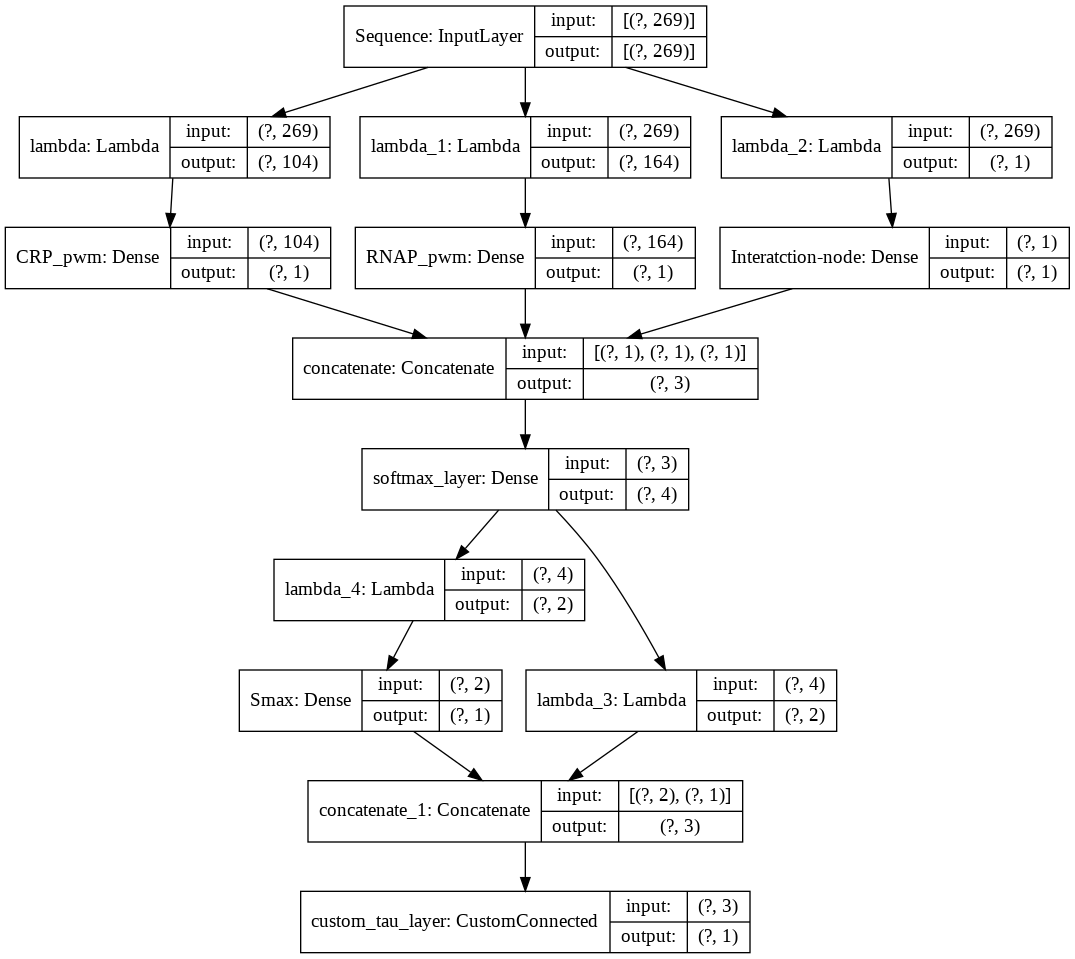

In [0]:

from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [0]:
model.layers

In [0]:

print('PWM layers')
print(np.shape(model.layers[4].get_weights()[0]))
print(np.shape(model.layers[5].get_weights()[0]))
print(np.shape(model.layers[6].get_weights()[0]))

print('Softmax layer')
print(np.shape(model.layers[8].get_weights()))

print(model.layers[9])
print('Smax')
print(np.shape(model.layers[11].get_weights())) # need to be set ones
print(model.layers[11].get_weights()) # need to be set ones

print('Concatenate')
print(model.layers[12])

print('input to tau')
print(model.layers[13].get_weights())

PWM layers
(104, 1)
(164, 1)
(1, 1)
Softmax layer
(1, 3, 4)
Smax
(1, 2, 1)
[array([[-1.2950613],
       [ 0.9568175]], dtype=float32)]
Concatenate
input to tau
[array([[-0.42752063],
       [ 0.6867857 ],
       [ 0.4274094 ]], dtype=float32)]


In [0]:
ones_s3s4_weights = model.layers[11].get_weights()[0].copy()
ones_s3s4_weights.shape

(2, 1)

In [0]:
# keep weights going to into smax fixed at
smax_fixed_ones_weights = np.array([1,1])
smax_fixed_ones_weights = smax_fixed_ones_weights.reshape(2,1)

model.layers[11].set_weights([smax_fixed_ones_weights])
model.layers[11].get_weights()[0]

array([[1.],
       [1.]], dtype=float32)

In [0]:
tau_layer_weights = model.layers[13].get_weights()[0].copy()
tau_layer_weights.shape

(3, 1)

In [0]:
tau_layer_initial_weights = np.array([0,0,1])
tau_layer_initial_weights = tau_layer_initial_weights.reshape(3,1)

model.layers[13].set_weights([tau_layer_initial_weights])
model.layers[13].get_weights()[0]

array([[0.],
       [0.],
       [1.]], dtype=float32)

In [0]:
# the following are the input weights to the softmax array.
# the first two arrays indicate 4 weights each coming out of the e_c and 
# e_r nodes. The last node indicates the gamma input, connecting only to
# microstate 4.

#softmax_weights = np.array([[0,1,0,1],[0,0,1,1]]) # this works
softmax_weights = np.array([[0,1,0,1],[0,0,1,1],[0,0,0,1]]) # this works
#softmax_weights = np.array([[0,0,1,1],[0,1,0,1]])
#softmax_biases = np.array([0,0,0,1])

# keras' set_weights expects weights and bias in a list
#softmax_weights = [softmax_biases,softmax_weights]

# without bias
softmax_weights = [softmax_weights]

# set weights
model.layers[8].set_weights(softmax_weights)
# see set weights
model.layers[8].get_weights()

[array([[0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], dtype=float32)]

In [0]:
np.array(X_train).shape[0]

39793

In [0]:
input_sequences_tensor2 = []
test_input_sequences_tensor2 = []

for _ in range(len(input_seqs_ohe)):
    temp = input_seqs_ohe[_].flatten()
    temp = np.append(temp,1)
    #input_seqs_ohe[_] = np.append(input_seqs_ohe[_],1)
    input_sequences_tensor2.append(temp)
    
for _ in range(len(test_seqs_ohe)):
    
    temp = test_seqs_ohe[_].flatten()
    temp = np.append(temp,1)
    test_input_sequences_tensor2.append(temp)

In [0]:
input_sequences_tensor2 = np.array(input_sequences_tensor2)
test_input_sequences_tensor2 = np.array(test_input_sequences_tensor2)

In [0]:
# input_seqs_ohe = np.array(input_seqs_ohe)
# input_sequences_tensor = input_seqs_ohe.reshape(-1,len(input_seqs_ohe[0])*4+1)

# test_seqs_ohe = np.array(test_seqs_ohe)
# test_input_sequences_tensor = test_seqs_ohe.reshape(-1,len(test_seqs_ohe[0])*4+1)

labels = np.array(y_train)
test_labels = np.array(y_test)

In [0]:
######
## Define custom function for keras
######

#K.clear_session()

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)


In [0]:
#model.compile(loss=log_poisson_loss,optimizer=Adam(lr=0.00001), metrics=['categorical_accuracy'])
#model.compile(loss=log_poisson_loss,optimizer=Adam(lr=0.0005), metrics=['mean_squared_error','mean_absolute_error'])
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.00075), metrics=['mean_absolute_error'])

In [0]:
# history = model.fit([input_sequences_tensor,gamma_input_list], labels, 
#                     validation_split=0.1, epochs=100,verbose=1,callbacks=[esCallBack,tbCallBack])  

history = model.fit(input_sequences_tensor2, labels, validation_split=0.2, epochs=400,verbose=1,batch_size=1000)

Train on 31834 samples, validate on 7959 samples
Epoch 1/400
31834/31834 [==============================] - 1s 35us/sample - loss: 0.4504 - mean_absolute_error: 0.5297 - val_loss: 0.3988 - val_mean_absolute_error: 0.4579
Epoch 2/400
31834/31834 [==============================] - 0s 7us/sample - loss: 0.4045 - mean_absolute_error: 0.4308 - val_loss: 0.3871 - val_mean_absolute_error: 0.4103
Epoch 3/400
31834/31834 [==============================] - 0s 7us/sample - loss: 0.3986 - mean_absolute_error: 0.4101 - val_loss: 0.3829 - val_mean_absolute_error: 0.4069
Epoch 4/400
31834/31834 [==============================] - 0s 7us/sample - loss: 0.3942 - mean_absolute_error: 0.4098 - val_loss: 0.3785 - val_mean_absolute_error: 0.4063
Epoch 5/400
31834/31834 [==============================] - 0s 7us/sample - loss: 0.3895 - mean_absolute_error: 0.4077 - val_loss: 0.3740 - val_mean_absolute_error: 0.4057
Epoch 6/400
31834/31834 [==============================] - 0s 7us/sample - loss: 0.3848 - mean_

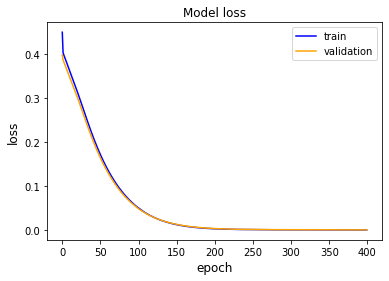

In [0]:
# plot losses

plt.figure()
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

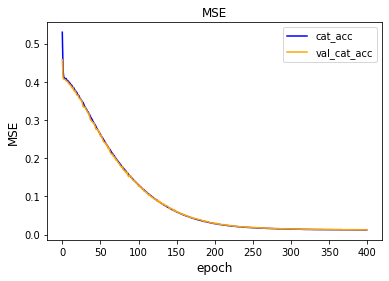

In [0]:
plt.figure()
plt.plot(history.history['mean_absolute_error'],color='blue')
plt.plot(history.history['val_mean_absolute_error'],color='orange')
plt.title('MSE',fontsize=12)
plt.ylabel('MSE',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['cat_acc', 'val_cat_acc'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

In [0]:
# predictions_on_test = model.predict(test_input_sequences_tensor)
predictions_on_test = model.predict(test_input_sequences_tensor2)

In [0]:
model_prediction = predictions_on_test

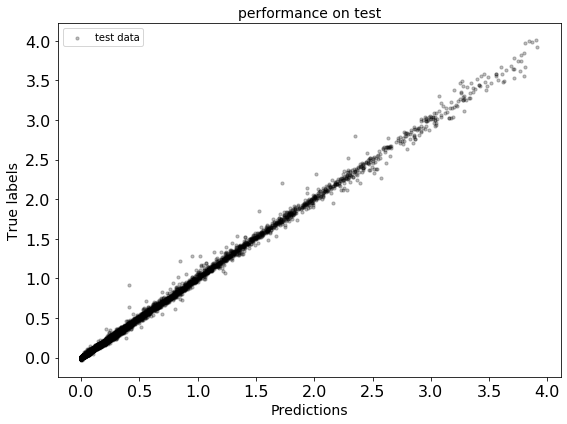

In [0]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(model_prediction, y_test)
linear_reg_y_pred = regr.predict(model_prediction)

figure_size = [8,6]
plt.figure(figsize=figure_size)
plt.scatter(model_prediction,y_test,alpha=0.25,s=10,color='black',label='test data')
#plt.plot(model_prediction,linear_reg_y_pred,color='black',linewidth=2,alpha=0.75,label='linear fit')
plt.xlabel('Predictions',fontsize=14)
plt.ylabel('True labels',fontsize=14)
plt.title('performance on test',fontsize=14)
plt.legend()

plt.tick_params(labelsize=16)
#plt.savefig('predictions_vs_measurements_beta_lactamase_ben_lehner_model.png')
plt.tight_layout()
plt.show()

In [0]:
crp_weights = model.layers[4].get_weights()[0].copy()
rnap_weights = model.layers[5].get_weights()[0].copy()

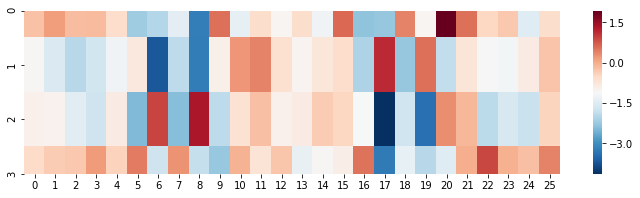

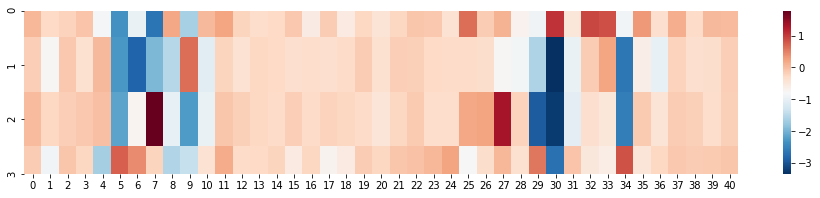

In [0]:
crp_weights = crp_weights.reshape(26,4)
rnap_weights = rnap_weights.reshape(41,4)


plt.figure(figsize=(12,3))
sns.heatmap(crp_weights.T,cmap='RdBu_r')
plt.show()
plt.figure(figsize=(16,3))
sns.heatmap(rnap_weights.T,cmap='RdBu_r')
#sns.heatmap(rnap_weights.T,cmap='RdBu_r')
plt.show()

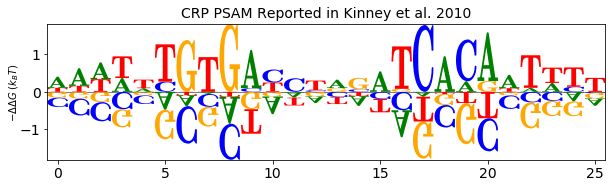

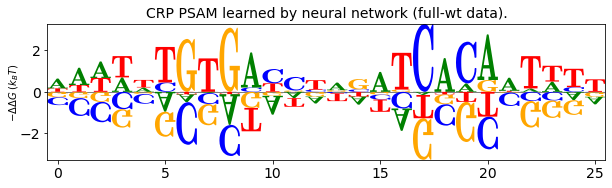

In [0]:
import logomaker
crp_logo_df = pd.DataFrame(crp_weights,columns=['A','C','G','T'])

crp_df.columns = ['A','C','G','T']
logomaker.Logo(-crp_df,center_values=True, font_name='cmb10')
plt.tick_params(labelsize=14)
plt.title('CRP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
logomaker.Logo(crp_logo_df,center_values=True, font_name='cmb10')
plt.title('CRP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)

plt.show()
#logomaker.Logo(rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')

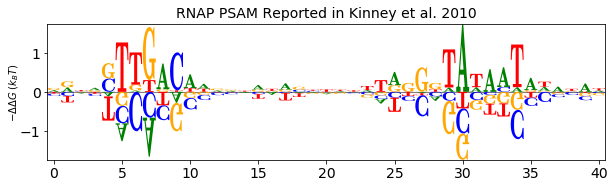

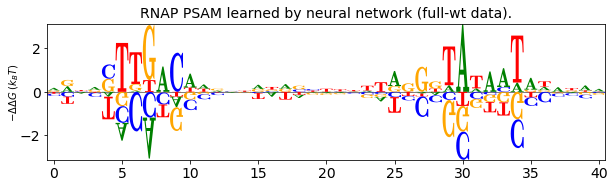

In [0]:
rnap_logo_df = pd.DataFrame(rnap_weights,columns=['A','C','G','T'])
rnap_df.columns = ['A','C','G','T']
logomaker.Logo(-rnap_df,center_values=True, font_name='cmb10')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
logomaker.Logo(rnap_logo_df,center_values=True, font_name='cmb10')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{B}T$)", labelpad=-1)
plt.tick_params(labelsize=14)

In [0]:
e_i_model = Model(inputs=model.input,outputs=model.layers[6].output)
e_i_node_output = e_i_model.predict([test_input_sequences_tensor2])

In [0]:
e_i_node_output[0]

array([4.814343], dtype=float32)

In [0]:
model.layers[8].get_weights()

[array([[0., 1., 0., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]], dtype=float32)]

In [0]:
model.layers[11].get_weights()

[array([[1.],
        [1.]], dtype=float32)]

In [0]:
model.layers[13].get_weights()

[array([[0.      ],
        [0.      ],
        [3.983374]], dtype=float32)]